In [ ]:
from google.colab import drive
drive.mount('/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/


In [ ]:
!pip3 install --quiet tensorflow==1.15
!pip3 install --quiet "tensorflow_hub>=0.6.0"
!pip3 install --quiet tensorflow_text==1.15

import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from collections import Counter
import itertools
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

     |████████████████████████████████| 412.3MB 21kB/s 
     |████████████████████████████████| 3.8MB 37.6MB/s 
     |████████████████████████████████| 512kB 50.8MB/s 
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 9.1MB 2.4MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

tf.logging.set_verbosity(tf.logging.ERROR)

session = tf.Session()
session.run([tf.global_variables_initializer(), tf.tables_initializer()])
message_embeddings = session.run(embed(messages))

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.04498472809791565, -0.057433921843767166, 0.0022114901803433895, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.055680178105831146, -0.009607940912246704, 0.006246272940188646, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.03874940052628517, 0.0765201598405838, -0.000794590450823307, ...]



In [ ]:

test_data = pd.read_csv('/gdrive/My Drive/NLA_project/test_1b.csv')
train_data = pd.read_csv('/gdrive/My Drive/NLA_project/train_1b_spl.csv')

labels_map = {'method_citation': 'MC', 'results_citation': 'RC', 'aim_citation': 'AC', 'implication_citation': 'IC', 'method citation': 'MC', 'hypothesis_citation': 'HC','result_citation':'RC','result citation':'RC'}
y_train = train_data['label'].values
y_test = test_data['label'].values

y_train = np.array([labels_map[lab.lower()] for lab in y_train])
y_test = np.array([labels_map[lab.lower()] for lab in y_test])
X = []
for a in train_data['Ref_text']:
	X.append(np.str_(a))
for a in test_data['Ref_text']:
	X.append(np.str_(a))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X).toarray()
print(X.shape)
# X = np.array(session.run(embed(X)))

(810, 2841)


In [ ]:
log_model = LogisticRegression()
train_size = len(y_train)
log_model = log_model.fit(X=X[:train_size], y=y_train)
y_pred = log_model.predict(X[train_size:])
print(accuracy_score(y_pred, y_test))
word_counts = Counter(itertools.chain(y_pred))
print(word_counts)

word_counts = Counter(itertools.chain(y_test))
print(word_counts)


0.6822429906542056
Counter({'MC': 214})
Counter({'MC': 146, 'RC': 34, 'IC': 15, 'AC': 10, 'HC': 9})


(810,)
Counter({'MC': 565, 'RC': 105, 'AC': 62, 'IC': 60, 'HC': 18})


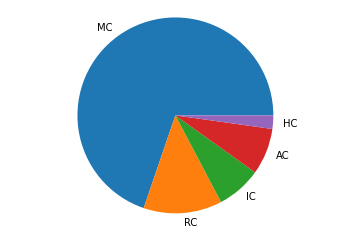

In [ ]:
labels = np.concatenate((y_train, y_test))
print(labels.shape)
# func = lambda a : a.lower()
# labels = list(map(func, labels))
word_counts = Counter(itertools.chain(labels))
print(word_counts)

fig1, ax1 = plt.subplots()
ax1.pie(word_counts.values(), labels=word_counts.keys())
ax1.axis('equal')
plt.show()

In [ ]:
!pip3 install catboost
import catboost as cbt
labels_step_1 = []
for lab in labels:
  if lab == 'MC':
    labels_step_1.append((0, lab))
  else:
    labels_step_1.append((1, lab))

X_train_1, X_test_1, y_train_bin, y_test_bin = train_test_split(X, np.array(labels_step_1), test_size=0.2, random_state=42)
print(X_train_1.shape, X_test_1.shape, y_train_bin.shape, y_test_bin.shape)
y_train_1 = np.array([x[0] for x in y_train_bin])
y_test_1 = np.array([x[0] for x in y_test_bin])

# log_model = RandomForestClassifier(warm_start=True, class_weight='balanced',n_estimators=200)
log_model = LogisticRegression(solver='saga',max_iter=500,C=0.5)
# log_model = cbt.CatBoostClassifier()
log_model = log_model.fit(X=X_train_1, y=y_train_1)
y_pred_1 = log_model.predict(X_test_1)

print(accuracy_score(y_pred_1, y_test_1))
tn, fp, fn, tp = confusion_matrix(y_test_1, y_pred_1).ravel()
print((tn, fp, fn, tp))

(648, 512) (162, 512) (648, 2) (162, 2)
0.691358024691358
(105, 1, 49, 7)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_1, y_test_1))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       154
           1       0.12      0.88      0.22         8

    accuracy                           0.69       162
   macro avg       0.56      0.78      0.51       162
weighted avg       0.95      0.69      0.78       162



In [ ]:
X_step_2 = []
Y_step_2 = []
for i,lab in enumerate(labels):
  if lab != 'MC':
    # print(i, X[i])
    X_step_2.append(X[i])
    Y_step_2.append(lab)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(np.array(X_step_2), np.array(Y_step_2), test_size=0.2, random_state=42)

print(X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape)

# log_model = RandomForestClassifier(warm_start=True, class_weight='balanced',n_estimators=200)
log_model = LogisticRegression(solver='saga',max_iter=500,C=0.5)
# log_model2 = SVC(kernel = 'linear', C = 0.5)
# log_model2 = cbt.CatBoostClassifier()
# log_model = KNeighborsClassifier(n_neighbors = 10)
log_model2 = log_model2.fit(X=X_train_2, y=y_train_2)
y_pred_2 = log_model2.predict(X_test_2)

print(accuracy_score(y_pred_2, y_test_2))
print(classification_report(y_pred_2, y_test_2))

(196, 2841) (49, 2841) (196,) (49,)
Learning rate set to 0.072816
0:	learn: 1.3639212	total: 32.4ms	remaining: 32.4s
1:	learn: 1.3430723	total: 58.1ms	remaining: 29s
2:	learn: 1.3228701	total: 75.9ms	remaining: 25.2s
3:	learn: 1.3022440	total: 93.7ms	remaining: 23.3s
4:	learn: 1.2879925	total: 112ms	remaining: 22.3s
5:	learn: 1.2753394	total: 130ms	remaining: 21.5s
6:	learn: 1.2583436	total: 147ms	remaining: 20.8s
7:	learn: 1.2449325	total: 167ms	remaining: 20.7s
8:	learn: 1.2316653	total: 186ms	remaining: 20.4s
9:	learn: 1.2208189	total: 204ms	remaining: 20.2s
10:	learn: 1.2123031	total: 221ms	remaining: 19.9s
11:	learn: 1.2028158	total: 238ms	remaining: 19.6s
12:	learn: 1.1944068	total: 256ms	remaining: 19.5s
13:	learn: 1.1860619	total: 275ms	remaining: 19.4s
14:	learn: 1.1769524	total: 293ms	remaining: 19.2s
15:	learn: 1.1651179	total: 310ms	remaining: 19.1s
16:	learn: 1.1575000	total: 328ms	remaining: 19s
17:	learn: 1.1525752	total: 346ms	remaining: 18.9s
18:	learn: 1.1440939	total

In [ ]:
final_predictions = []
final_grnd_truth = []
# print(y_pred_1)
# print(sum(y_pred_1), len(y_pred_1))
for i, lab in enumerate(y_pred_1):
  if lab == '1':
    final_predictions.append(log_model2.predict(np.array([X_test_1[i]]))[0])
    final_grnd_truth.append(y_test_bin[i][1])
  else:
    # print(y_test_bin[i][1])
    final_predictions.append('MC')
    final_grnd_truth.append(y_test_bin[i][1])
print(np.array(final_predictions).shape, np.array(final_grnd_truth).shape)
print(accuracy_score(final_predictions, final_grnd_truth))

(162,) (162,)
0.7530864197530864
